In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import re

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import missingno as msno

from mlxtend.evaluate import bias_variance_decomp
from mlxtend.feature_selection import SequentialFeatureSelector

from sklearn.linear_model import LogisticRegression, LinearRegression, Lasso, Ridge
from sklearn.metrics import classification_report, roc_auc_score, f1_score, mean_absolute_percentage_error, r2_score, mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

from statsmodels.stats.weightstats import ttest_ind

import nltk
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet, stopwords

In [4]:
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('punkt', quiet=True)
nltk.download('punkt_tab', quiet=True)
nltk.download('omw-1.4', quiet=True)
nltk.download('averaged_perceptron_tagger_eng', quiet=True)

True

In [5]:
RANDOM_STATE = 42

### **Отбор признаков**

**Отбор признаков** (feature selection) — это процесс выбора наиболее информативных переменных из исходного набора данных. Такой подход позволяет упростить модель, сократить время обучения, повысить точность и уменьшить переобучение. Существует три основные группы методов: фильтры, обёртки и встроенные методы.

**Фильтры (filter methods)** 

Фильтры оценивают важность признаков на основе статистических критериев независимо от используемой модели машинного обучения. Признаки оцениваются по отдельности, а затем выбирается подмножество признаков, которые лучше всего коррелируют с целевой переменной.

Такие методы просты в реализации и быстры, но не учитывают взаимодействие между признаками и специфику модели. 

Примеры методов: 

* Корреляционный анализ.

* Критерий $\chi^2$ (хи-квадрат).

* ANOVA F-тест.

**Обёртки (wrapper methods)**

Обёртки используют модели для оценки качества различных подмножеств признаков. Эти методы перебирают различные комбинации признаков, обучают модель и сравнивают качество прогнозов.

Такие методы способны учитывать взаимодействие признаков и специфику модели, но вычислительно затратны.

Примеры методов:

* SFS (Sequential Forward Selection). Отбор начинается с пустого множества признаков. На каждом шаге к текущему набору добавляется тот признак, который при включении даёт наибольшее улучшение качества модели. Процесс продолжается до тех пор, когда не будет достигнут заданный размер подмножества или когда дальнейшее добавление признаков не будет улучшать качество.

* SBS (Sequential Backward Selection). Отбор начинается со всех признаков. На каждом шаге удаляется тот признак, чьё исключение меньше всего ухудшает качество модели. Процесс повторяется, пока не останется заданное число признаков.

* RFE (Recursive Feature Elimination). Отбор осуществляется на основе коэффициентов или важности признаков в обученной модели путем удаления наименее значимого признака. Процесс повторяется рекурсивно, пока не останется заданное количество признаков.

**Встроенные методы (embedded methods)**

Встроенные методы производят отбор признаков непосредственно в процессе обучения модели: используются внутренние механизмы модели для определения важности признаков. 

Встроенные методы сочетают преимущества фильтрующих (скорость) и оберточных (учет специфики модели) методов. 

Примеры методов: 

* L1-регуляризация (LASSO) для линейных моделей.

* Feature Importance в деревьях решений и ансамблевых методах (Random Forest, Gradient Boosting).

*На практике перечисленные методы могут комбинироваться. Например, сначала с помощью фильтра убираются малоинформативные признаки, а затем применяется обёртка для более точного отбора признаков.*

Подробнее можно изучить по **ссылкам:**

* [Comprehensive Guide on Feature Selection | kaggle.com](https://www.kaggle.com/code/prashant111/comprehensive-guide-on-feature-selection)

* [Отбор признаков (Feature selection) | scikit-learn.ru](https://scikit-learn.ru/stable/modules/feature_selection.html#univariate-feature-selection)

### **Датасет *Company Bankruptcy Prediction***

**Для решения задания 6 рассмотрим датасет [Company Bankruptcy Prediction](https://www.kaggle.com/datasets/fedesoriano/company-bankruptcy-prediction).**

**ВНИМАНИЕ:** При решении задания **используйте файл bankruptcy.csv** из приложения к ноутбуку, поскольку исходный датасет был изменен авторами курса.

Набор данных предназначен для выявления компаний с высоким риском банкротства на основе их финансовых показателей. Данные были собраны из базы данных компании Taiwan Economic Journal за период с 1999 по 2009 годы.

Целевая переменная — Bankrupt? (банкротство компании):

0 — в течение рассматриваемого периода компания работала без признаков банкротства.

1 — компания обанкротилась в течение рассматриваемого периода.

В датасете содержатся 95 различных показателей финансового состояния компаний, значения которых были предварительно стандартизированы.

Одной из особенностей набора данных является дисбаланс классов в целевой переменной: только 3.22% от числа компаний в выборке были признаны банкротами за указанный период. 

In [91]:
# Считайте данные

df_bankr = pd.read_csv('bankruptcy.csv')
df_bankr

,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,...,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
0,1,0.370594,0.424389,0.405750,0.601457,0.601457,0.998969,0.796887,0.808809,0.302646,...,0.716845,0.009219,0.622879,0.601453,0.827890,0.290202,0.026601,0.564050,1,0.016469
1,1,0.464291,0.538214,0.516730,0.610235,0.610235,0.998946,0.797380,0.809301,0.303556,...,0.795297,0.008323,0.623652,0.610237,0.839969,0.283846,0.264577,0.570175,1,0.020794
2,1,0.426071,0.499019,0.472295,0.601450,0.601364,0.998857,0.796403,0.808388,0.302035,...,0.774670,0.040003,0.623841,0.601449,0.836774,0.290189,0.026555,0.563706,1,0.016474
3,1,0.399844,0.451265,0.457733,0.583541,0.583541,0.998700,0.796967,0.808966,0.303350,...,0.739555,0.003252,0.622929,0.583538,0.834697,0.281721,0.026697,0.564663,1,0.023982
4,1,0.465022,0.538432,0.522298,0.598783,0.598783,0.998973,0.797366,0.809304,0.303475,...,0.795016,0.003878,0.623521,0.598782,0.839973,0.278514,0.024752,0.575617,1,0.035490
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6814,0,0.493687,0.539468,0.543230,0.604455,0.604462,0.998992,0.797409,0.809331,0.303510,...,0.799927,0.000466,0.623620,0.604455,0.840359,0.279606,0.027064,0.566193,1,0.029890
6815,0,0.475162,0.538269,0.524172,0.598308,0.598308,0.998992,0.797414,0.809327,0.303520,...,0.799748,0.001959,0.623931,0.598306,0.840306,0.278132,0.027009,0.566018,1,0.038284
6816,0,0.472725,0.533744,0.520638,0.610444,0.610213,0.998984,0.797401,0.809317,0.303512,...,0.797778,0.002840,0.624156,0.610441,0.840138,0.275789,0.026791,0.565158,1,0.097649
6817,0,0.506264,0.559911,0.554045,0.607850,0.607850,0.999074,0.797500,0.809399,0.303498,...,0.811808,0.002837,0.623957,0.607846,0.841084,0.277547,0.026822,0.565302,1,0.044009


In [92]:
# Всего в датасете 95 признаков (без учета целевой переменной)
# Пропущенные значения отсутствуют 

df_bankr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6819 entries, 0 to 6818
Data columns (total 96 columns):
 #   Column                                                   Non-Null Count  Dtype  
---  ------                                                   --------------  -----  
 0   Bankrupt?                                                6819 non-null   int64  
 1   ROA(C) before interest and depreciation before interest  6819 non-null   float64
 2   ROA(A) before interest and % after tax                   6819 non-null   float64
 3   ROA(B) before interest and depreciation after tax        6819 non-null   float64
 4   Operating Gross Margin                                   6819 non-null   float64
 5   Realized Sales Gross Margin                              6819 non-null   float64
 6   Operating Profit Rate                                    6819 non-null   float64
 7   Pre-tax net Interest Rate                                6819 non-null   float64
 8   After-tax net Interest Rate 

In [93]:
# В датасете присутствует дисбаланс классов

df_bankr['Bankrupt?'].value_counts(normalize=True)

Bankrupt?
0    0.967737
1    0.032263
Name: proportion, dtype: float64

In [94]:
# Выделите объясняемый фактор в отдельную переменную

X_bankr = df_bankr.drop('Bankrupt?', axis=1)
y_bankr = df_bankr['Bankrupt?']

In [95]:
# Разделите датасет на обучающую (60%) и тестовую (40%) выборки со стратификацией по целевой переменной
# Не забудьте зафиксировать RANDOM_STATE

X_bankr_train, X_bankr_test, y_bankr_train, y_bankr_test = train_test_split(
    X_bankr, y_bankr,
    test_size=0.4,
    stratify=y_bankr,
    random_state=RANDOM_STATE
)

In [96]:
# Обучите baseline модель lr_bankr_baseline
# Не забудьте зафиксировать RANDOM_STATE

lr_bankr_baseline = LogisticRegression(random_state=RANDOM_STATE, solver='liblinear', class_weight='balanced')
lr_bankr_baseline.fit(X_bankr_train, y_bankr_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,'balanced'
,random_state,42
,solver,'liblinear'
,max_iter,100
,multi_class,'deprecated'


In [97]:
# Постройте отчет по метрикам классификации для модели lr_bankr на тестовой выборке

# Получаем предсказания
y_bankr_pred_baseline = lr_bankr_baseline.predict(X_bankr_test)
y_bankr_pred_proba_baseline = lr_bankr_baseline.predict_proba(X_bankr_test)

# Выводим основные метрики
print("Baseline модель - метрики на тестовой выборке:")
print(f"Accuracy: {accuracy_score(y_bankr_test, y_bankr_pred_baseline):.4f}")
print(f"Precision: {precision_score(y_bankr_test, y_bankr_pred_baseline):.4f}")
print(f"Recall: {recall_score(y_bankr_test, y_bankr_pred_baseline):.4f}")
print(f"F1-score: {f1_score(y_bankr_test, y_bankr_pred_baseline):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_bankr_test, y_bankr_pred_proba_baseline[:, 1]):.4f}")

print("\nClassification Report:")
print(classification_report(y_bankr_test, y_bankr_pred_baseline))

Baseline модель - метрики на тестовой выборке:
Accuracy: 0.7834
Precision: 0.0549
Recall: 0.3523
F1-score: 0.0949
ROC-AUC: 0.6397

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.80      0.88      2640
           1       0.05      0.35      0.09        88

    accuracy                           0.78      2728
   macro avg       0.51      0.57      0.49      2728
weighted avg       0.94      0.78      0.85      2728



In [98]:
# Анализ важности признаков (топ-10)
feature_importance = pd.DataFrame({
    'feature': X_bankr.columns,
    'importance': lr_bankr_baseline.coef_[0]
}).sort_values('importance', key=abs, ascending=False)

print("\nТоп-10 самых важных признаков:")
print(feature_importance.head(10))


Топ-10 самых важных признаков:
                                feature    importance
45         Accounts Receivable Turnover -2.005098e-08
46              Average Collection Days -1.705976e-08
52           Allocation rate per person -4.129478e-09
13  Interest-bearing debt interest rate -3.969827e-09
57       Quick Assets/Current Liability -9.957474e-10
35           Total debt/Total net worth  5.152105e-10
86            Total assets to GNP price  3.636426e-10
58               Cash/Current Liability  3.535799e-10
33                          Quick Ratio  2.311822e-10
29                Net Value Growth Rate -1.782819e-10


In [99]:
# Посчитайте AUC для модели lr_bankr_baseline на тестовой выборке

print(f"ROC-AUC: {roc_auc_score(y_bankr_test, y_bankr_pred_proba_baseline[:, 1]):.4f}")

ROC-AUC: 0.6397


In [100]:
# Постройте пайплайн bankr_kbest_pipeline (см. задание)
# Не забудьте зафиксировать RANDOM_STATE

bankr_kbest_pipeline = Pipeline([
    ('selector', SelectKBest(f_classif)),
    ('clf', LogisticRegression(random_state=RANDOM_STATE, solver='liblinear', class_weight='balanced'))
])

In [101]:
# Проверяем структуру пайплайна
print("Структура пайплайна:")
for step_name, step in bankr_kbest_pipeline.named_steps.items():
    print(f"{step_name}: {step}")

# Проверяем параметры пайплайна
print("\nДоступные параметры для настройки:")
print(bankr_kbest_pipeline.get_params().keys())

Структура пайплайна:
selector: SelectKBest()
clf: LogisticRegression(class_weight='balanced', random_state=42, solver='liblinear')

Доступные параметры для настройки:
dict_keys(['memory', 'steps', 'transform_input', 'verbose', 'selector', 'clf', 'selector__k', 'selector__score_func', 'clf__C', 'clf__class_weight', 'clf__dual', 'clf__fit_intercept', 'clf__intercept_scaling', 'clf__l1_ratio', 'clf__max_iter', 'clf__multi_class', 'clf__n_jobs', 'clf__penalty', 'clf__random_state', 'clf__solver', 'clf__tol', 'clf__verbose', 'clf__warm_start'])


In [102]:
# С помощью GridSearchCV и bankr_kbest_pipeline подберите на обучающей выборке оптимальное количество признаков

params = {
    'selector__k': range(1, 40)
}
scoring = 'f1'
cv = 5

cv_lr_bankr_kbest = GridSearchCV(
    estimator=bankr_kbest_pipeline, 
    param_grid=params,
    scoring=scoring,
    cv=cv, 
    n_jobs=-1
).fit(X_bankr_train, y_bankr_train)

In [103]:
# Получаем лучшую модель и параметры
lr_bankr_kbest = cv_lr_bankr_kbest.best_estimator_
best_k = cv_lr_bankr_kbest.best_params_['selector__k']
best_f1 = cv_lr_bankr_kbest.best_score_

print(f"Оптимальное количество признаков: {best_k}")
print(f"Лучший F1-score на кросс-валидации: {best_f1:.4f}")

# Смотрим все результаты
results_df = pd.DataFrame(cv_lr_bankr_kbest.cv_results_)
print("\nТоп-5 результатов по количеству признаков:")
top_results = results_df.nlargest(5, 'mean_test_score')[['param_selector__k', 'mean_test_score', 'std_test_score']]
print(top_results)

Оптимальное количество признаков: 7
Лучший F1-score на кросс-валидации: 0.2766

Топ-5 результатов по количеству признаков:
    param_selector__k  mean_test_score  std_test_score
6                   7         0.276610        0.026040
9                  10         0.276180        0.027986
8                   9         0.275663        0.025886
10                 11         0.275114        0.027482
26                 27         0.273538        0.028850


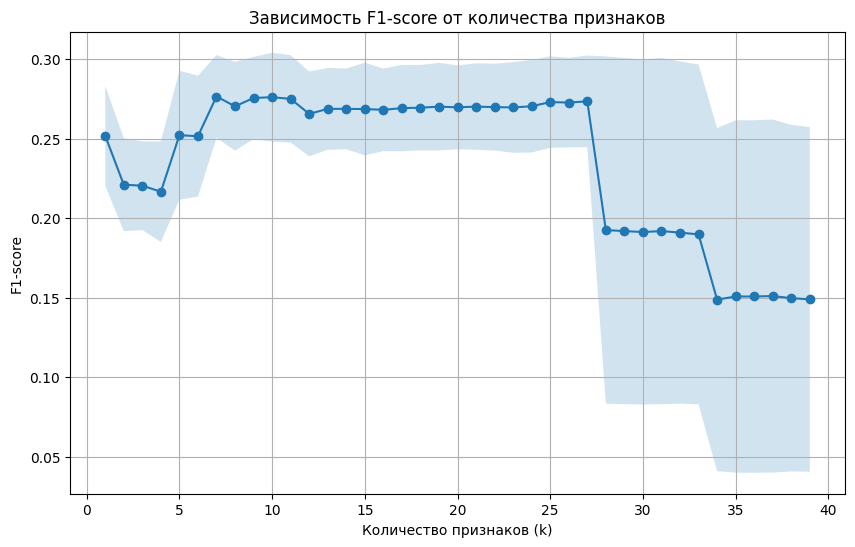

In [104]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(results_df['param_selector__k'], results_df['mean_test_score'], marker='o')
plt.fill_between(results_df['param_selector__k'], 
                 results_df['mean_test_score'] - results_df['std_test_score'],
                 results_df['mean_test_score'] + results_df['std_test_score'], 
                 alpha=0.2)
plt.xlabel('Количество признаков (k)')
plt.ylabel('F1-score')
plt.title('Зависимость F1-score от количества признаков')
plt.grid(True)
plt.show()

In [105]:
# На наборе из оптимального числа признаков на всей обучающей выборке обучите модель lr_bankr_kbest

lr_bankr_kbest = cv_lr_bankr_kbest.best_estimator_

In [106]:
# Постройте отчет по метрикам классификации для модели lr_bankr_kbest на тестовой выборке

y_bankr_pred_kbest = lr_bankr_kbest.predict(X_bankr_test)
y_bankr_pred_proba_kbest = lr_bankr_kbest.predict_proba(X_bankr_test)

print("Модель с отбором признаков - метрики на тестовой выборке:")
print(f"Accuracy: {accuracy_score(y_bankr_test, y_bankr_pred_kbest):.4f}")
print(f"Precision: {precision_score(y_bankr_test, y_bankr_pred_kbest):.4f}")
print(f"Recall: {recall_score(y_bankr_test, y_bankr_pred_kbest):.4f}")

Модель с отбором признаков - метрики на тестовой выборке:
Accuracy: 0.8457
Precision: 0.1567
Recall: 0.8636


In [107]:
# Посчитайте f1 для модели lr_bankr_kbest на тестовой выборке

f1_kbest = f1_score(y_bankr_test, y_bankr_pred_kbest)
print(f"F1-score: {f1_kbest:.4f}")

F1-score: 0.2653


In [108]:
# Посчитайте AUC для модели lr_bankr_kbest на тестовой выборке

auc_kbest = roc_auc_score(y_bankr_test, y_bankr_pred_proba_kbest[:, 1])
print(f"ROC-AUC: {auc_kbest:.4f}")

print("\nClassification Report:")
print(classification_report(y_bankr_test, y_bankr_pred_kbest))

print("\nConfusion Matrix:")
print(confusion_matrix(y_bankr_test, y_bankr_pred_kbest))

ROC-AUC: 0.9280

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.85      0.91      2640
           1       0.16      0.86      0.27        88

    accuracy                           0.85      2728
   macro avg       0.58      0.85      0.59      2728
weighted avg       0.97      0.85      0.89      2728


Confusion Matrix:
[[2231  409]
 [  12   76]]


In [109]:
# Используя SequentialFeatureSelector, подберите на обучающей выборке оптимальный набор признаков
# Не забудьте зафиксировать RANDOM_STATE

bankr_sfs = SequentialFeatureSelector(
    estimator=LogisticRegression(random_state=RANDOM_STATE, solver='liblinear', class_weight='balanced'), 
    k_features='best', 
    forward=True, 
    floating=False,
    scoring='f1',
    cv=5,
    n_jobs=-1
).fit(X_bankr_train, y_bankr_train)

In [110]:
# Выведите оптимальное количество признаков после SFS

optimal_features_count = len(bankr_sfs.k_feature_idx_)
print(f"Оптимальное количество признаков после SequentialFeatureSelector: {optimal_features_count}")

Оптимальное количество признаков после SequentialFeatureSelector: 9


In [111]:
# Создайте новые выборки с оптимальными признаками после SFS

X_bankr_train_sfs = bankr_sfs.transform(X_bankr_train)
X_bankr_test_sfs = bankr_sfs.transform(X_bankr_test)

In [112]:
# На оптимальном наборе признаков на всей обучающей выборке обучите модель lr_bankr_sfs
# Не забудьте зафиксировать RANDOM_STATE

lr_bankr_sfs = LogisticRegression(random_state=RANDOM_STATE, solver='liblinear', class_weight='balanced')
lr_bankr_sfs.fit(X_bankr_train_sfs, y_bankr_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,'balanced'
,random_state,42
,solver,'liblinear'
,max_iter,100
,multi_class,'deprecated'


In [113]:
# Постройте отчет по метрикам классификации для модели lr_bankr_sfs на тестовой выборке

# Получаем предсказания для SFS модели
y_bankr_pred_sfs = lr_bankr_sfs.predict(X_bankr_test_sfs)
y_bankr_pred_proba_sfs = lr_bankr_sfs.predict_proba(X_bankr_test_sfs)

print("Модель с SequentialFeatureSelector - метрики на тестовой выборке:")
print(f"Accuracy: {accuracy_score(y_bankr_test, y_bankr_pred_sfs):.4f}")
print(f"Precision: {precision_score(y_bankr_test, y_bankr_pred_sfs):.4f}")
print(f"Recall: {recall_score(y_bankr_test, y_bankr_pred_sfs):.4f}")
print(f"F1-score: {f1_score(y_bankr_test, y_bankr_pred_sfs):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_bankr_test, y_bankr_pred_proba_sfs[:, 1]):.4f}")

Модель с SequentialFeatureSelector - метрики на тестовой выборке:
Accuracy: 0.9556
Precision: 0.3458
Recall: 0.4205
F1-score: 0.3795
ROC-AUC: 0.8217


In [114]:
# Сравниваем все три модели
print("\nСРАВНЕНИЕ ВСЕХ МОДЕЛЕЙ:")
print(f"{'Метрика':<12} {'Baseline':<10} {'KBest':<10} {'SFS':<10}")
print(f"{'-' * 45}")
print(f"{'Accuracy':<12} {accuracy_score(y_bankr_test, y_bankr_pred_baseline):.4f}     {accuracy_score(y_bankr_test, y_bankr_pred_kbest):.4f}     {accuracy_score(y_bankr_test, y_bankr_pred_sfs):.4f}")
print(f"{'Precision':<12} {precision_score(y_bankr_test, y_bankr_pred_baseline):.4f}     {precision_score(y_bankr_test, y_bankr_pred_kbest):.4f}     {precision_score(y_bankr_test, y_bankr_pred_sfs):.4f}")
print(f"{'Recall':<12} {recall_score(y_bankr_test, y_bankr_pred_baseline):.4f}     {recall_score(y_bankr_test, y_bankr_pred_kbest):.4f}     {recall_score(y_bankr_test, y_bankr_pred_sfs):.4f}")
print(f"{'F1-score':<12} {f1_score(y_bankr_test, y_bankr_pred_baseline):.4f}     {f1_kbest:.4f}     {f1_score(y_bankr_test, y_bankr_pred_sfs):.4f}")
print(f"{'ROC-AUC':<12} {roc_auc_score(y_bankr_test, y_bankr_pred_proba_baseline[:, 1]):.4f}     {auc_kbest:.4f}     {roc_auc_score(y_bankr_test, y_bankr_pred_proba_sfs[:, 1]):.4f}")


СРАВНЕНИЕ ВСЕХ МОДЕЛЕЙ:
Метрика      Baseline   KBest      SFS       
---------------------------------------------
Accuracy     0.7834     0.8457     0.9556
Precision    0.0549     0.1567     0.3458
Recall       0.3523     0.8636     0.4205
F1-score     0.0949     0.2653     0.3795
ROC-AUC      0.6397     0.9280     0.8217


In [115]:
# Посчитайте AUC для модели lr_bankr_sfs на тестовой выборке

...

Ellipsis

In [116]:
# С помощью GridSearchCV подберите на обучающей выборке значение оптимального гиперпараметра регуляризации C
# Не забудьте зафиксировать RANDOM_STATE

estimator = LogisticRegression(random_state=RANDOM_STATE, solver='liblinear', class_weight='balanced', penalty='l1')
params = {'C' : [0.001, 0.005, 0.01, 0.05, 0.1, 0.5]}
cv = 5
scoring = 'f1'

cv_lr_bankr_l1 = GridSearchCV(
    estimator=estimator,
    param_grid=params,
    scoring=scoring,
    cv=cv,
    n_jobs=-1
).fit(X_bankr_train, y_bankr_train)

In [117]:
# На всей обучающей выборке обучите модель с L1 регуляризацией lr_bankr_l1
# Не забудьте зафиксировать RANDOM_STATE

# Получаем лучшую модель и параметры
lr_bankr_l1 = cv_lr_bankr_l1.best_estimator_
best_C = cv_lr_bankr_l1.best_params_['C']
best_f1_l1 = cv_lr_bankr_l1.best_score_

print(f"Оптимальное значение C: {best_C}")
print(f"Лучший F1-score на кросс-валидации: {best_f1_l1:.4f}")

# Смотрим все результаты
results_df_l1 = pd.DataFrame(cv_lr_bankr_l1.cv_results_)
print("\nРезультаты для разных значений C:")
print(results_df_l1[['param_C', 'mean_test_score', 'std_test_score']])

Оптимальное значение C: 0.1
Лучший F1-score на кросс-валидации: 0.2748

Результаты для разных значений C:
   param_C  mean_test_score  std_test_score
0    0.001         0.099213        0.015853
1    0.005         0.099213        0.015853
2    0.010         0.099213        0.015905
3    0.050         0.259395        0.034470
4    0.100         0.274850        0.035014
5    0.500         0.272148        0.028971


In [119]:
# Оцениваем на тестовой выборке
y_bankr_pred_l1 = lr_bankr_l1.predict(X_bankr_test)
y_bankr_pred_proba_l1 = lr_bankr_l1.predict_proba(X_bankr_test)

print("\nL1-регуляризация - метрики на тестовой выборке:")
print(f"F1-score: {f1_score(y_bankr_test, y_bankr_pred_l1):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_bankr_test, y_bankr_pred_proba_l1[:, 1]):.4f}")


L1-регуляризация - метрики на тестовой выборке:
F1-score: 0.2710
ROC-AUC: 0.9117


In [120]:
# Анализируем, сколько признаков было отобрано L1-регуляризацией
non_zero_coefs = np.sum(lr_bankr_l1.coef_ != 0)
print(f"\nL1-регуляризация отобрала {non_zero_coefs} признаков из {X_bankr_train.shape[1]}")
print(f"Это {non_zero_coefs/X_bankr_train.shape[1]*100:.1f}% от исходного количества")

# Топ-10 самых важных признаков по L1
feature_importance_l1 = pd.DataFrame({
    'feature': X_bankr.columns,
    'coefficient': lr_bankr_l1.coef_[0],
    'abs_coef': np.abs(lr_bankr_l1.coef_[0])
}).sort_values('abs_coef', ascending=False)

print("\nТоп-10 самых важных признаков по L1:")
print(feature_importance_l1.head(10))


L1-регуляризация отобрала 29 признаков из 95
Это 30.5% от исходного количества

Топ-10 самых важных признаков по L1:
                                              feature  coefficient   abs_coef
36                                       Debt ratio %    18.946293  18.946293
0   ROA(C) before interest and depreciation before...   -10.945847  10.945847
1              ROA(A) before interest and % after tax    -1.850112   1.850112
5                               Operating Profit Rate     1.374936   1.374936
56                                  Cash/Total Assets    -1.336189   1.336189
75                             Fixed Assets to Assets     1.070675   1.070675
93                                    Net Income Flag     0.657191   0.657191
63                      Current Liabilities/Liability     0.312537   0.312537
14                                       Tax rate (A)    -0.304095   0.304095
76                     Current Liability to Liability     0.194075   0.194075


Для предсказания банкротства использовалась логистическая регрессия — прозрачный метод, позволяющий понять, какие финансовые показатели наиболее важны. Учитывая, что банкротов в данных всего 3%, применялись специальные методы балансировки и отбора признаков.

Baseline модель
Бинарная классификация, регрессия с class_weight='balanced'
- Риск переобучения при высокой размерности
- Наличие неинформативных финансовых показателей

Три основных подхода улучшения метрик:

1. Автоматический отбор — компьютер сам выбирает наиболее полезные финансовые показатели
SelectKBest: ANOVA F-тест для выбора k лучших признаков
2. Последовательный отбор — постепенное добавление показателей с проверкой их эффективности
SequentialFeatureSelector: Пошаговый отбор с forward selection
Учитывает взаимодействие признаков
3. L1-регуляризация — математический метод, автоматически отсекающий маловажные показатели

Baseline (все 95 признаков):
- F1: 0.0949
- ROC-AUC: 0.6397
- Precision: 0.0549
- Recall: 0.3523

SelectKBest:
- F1: 0.2653 (+0.1704)
- ROC-AUC: 0.9280 (+0.2883)
- Precision: 0.1567
- Recall: 0.8636
- Отобрано 7 из 95 признаков
- Улучшение F1-score с 0.095 до 0.265
- Рост ROC-AUC с 0.640 до 0.928
- Значительное улучшение recall до 0.864

SequentialFeatureSelector:
- F1: 0.3795
- ROC-AUC: 0.8217
- Precision: 0.3458
- Recall: 0.4205
- Отобрано 9 из 95 признаков
- Наивысшая точность (0.956) и precision (0.346)
- Более консервативный отбор признаков
- Лучшая специфичность модели

L1-регуляризация:
- F1: 0.2710
- ROC-AUC: 0.9117
- Отобрано 29 из 95 признаков (30.5%)
- Стабильное качество (F1: 0.271)
- Высокий ROC-AUC (0.912)
- Интерпретируемая модель

| Метод | Точность | Полнота | F1-скор |
|-------|----------|---------|----------|
| Базовый | 5.5% | 35.2% | 9.5% |
| Автоматический отбор | 15.7% | 86.4% | 26.5% |
| Последовательный отбор | 34.6% | 42.1% | 38.0% |
| L1-регуляризация | - | - | 27.1% |

SFS показал наилучшую точность (95.6%), но умеренное F1-score
KBest достиг лучшего баланса с высоким ROC-AUC (0.928) и хорошим recall
L1-регуляризация показала стабильные результаты на тесте vs валидации

Что работает лучше:
- Автоматический отбор показателей находит почти все банкротства (86%), но дает много ложных тревог
- Последовательный отбор обеспечивает баланс — каждый третий прогноз точен, при этом обнаруживается 42% реальных банкротств
- Все методы значительно улучшают базовый вариант

Самые важные показатели для прогноза:
Долговая нагрузка - главный индикатор проблем
Рентабельность активов - ключевой защитный фактор
Ликвидность - существенный, но менее важный показатель  

Нужно отличить здоровую компанию от проблемной. Мы пробовали три стратегии:

1. Широкий поиск — находим почти все проблемные компании, но ошибаемся в 85% случаев
2. Точный подход — ошибаемся реже, но пропускаем больше проблемных компаний
3. Сбалансированный метод — находим достаточно проблемных компаний и редко ошибаемся

Для корпоративного управления
- Мониторинг ключевых показателей (Debt ratio, ROA)
- Раннее выявление признаков финансового стресса
- Обоснование управленческих решений

Как улучшить?
- Добавить данные о рынке и экономической ситуации
- Учесть отраслевые особенности компаний
- Использовать более сложные алгоритмы для выявления скрытых закономерностей